In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from statistics import mean, median

In [24]:
env_name = "CartPole-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action space: Discrete(2)


In [25]:
env.reset()
#Number of frames
goal_steps = 500
score_requirement = 50
initial_games = 10000

In [26]:
def create_data():
    training_data, scores, accepted_scores = [], [], []
    for _ in range(initial_games):
        score = 0
        #Moves from current environment and previous observations
        game_memory, prev_observation = [], []
        for _ in range(goal_steps):
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            
            if len(prev_observation) > 0:
                game_memory.append([prev_observation, action])
                
            prev_observation = observation
            score += reward
            
            if done:
                break
            
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                training_data.append(data)
                    
        env.reset()        
        scores.append(score)
       
    print('Average accepted score:', mean(accepted_scores))
    print('Median accepted score:', median(accepted_scores))
        
    return training_data

In [27]:
def create_initial_pop(pop_size):
    initial_pop = np.random.uniform(low = -2.0, high = 2.0, size = pop_size)
    print('Initial Population:\n{}'.format(initial_pop))
    return initial_pop

def sigmoid(z):
    return 1/(1+np.exp(-z))

def predict(X):
    pred = np.empty((X.shape[0], 1))
    for i in range(X.shape[0]):
        if X[i] >= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
    return pred    

In [28]:
def cal_fitness(population, X, y, pop_size):
    fitness = np.empty((pop_size[0], 1))
    for i in range(pop_size[0]):
        hx  = X@(population[i]).T
        fitness[i][0] = np.sum(hx)
    return fitness

In [29]:
def selection(population, fitness, num_parents):
    fitness = list(fitness)
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

In [30]:
def crossover(parents, num_offsprings):
    offsprings = np.empty((num_offsprings, parents.shape[1]))
    crossover_point = int(parents.shape[1]/2)
    crossover_rate = 0.8
    i=0
    while (parents.shape[0] < num_offsprings):
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        x = random.random()
        if x > crossover_rate:
            continue
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        offsprings[i,0:crossover_point] = parents[parent1_index,0:crossover_point]
        offsprings[i,crossover_point:] = parents[parent2_index,crossover_point:]
        i=+1
    return offsprings    

In [31]:

def mutation(offsprings):
    mutants = np.empty((offsprings.shape))
    mutation_rate = 0.4
    for i in range(mutants.shape[0]):
        random_value = random.random()
        mutants[i,:] = offsprings[i,:]
        if random_value > mutation_rate:
            continue
        int_random_value = randint(0,offsprings.shape[1]-1)    
        mutants[i,int_random_value] += np.random.uniform(-1.0, 1.0, 1)
        
    return mutants

In [34]:
def GA_model(training_data):
    X = np.array([i[0] for i in training_data])
    y = np.array([i[1] for i in training_data]).reshape(-1, 1)
    
    weights = []
    num_solutions = 8
    pop_size = (num_solutions, X.shape[1])
    num_parents = int(pop_size[0]/2)
    num_offsprings = pop_size[0] - num_parents 
    num_generations = 50
    
    population = create_initial_pop(pop_size)
    
    for i in range(num_generations):
        fitness = cal_fitness(population, X, y, pop_size)
        parents = selection(population, fitness, num_parents)
        offsprings = crossover(parents, num_offsprings)
        mutants = mutation(offsprings)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = mutants
    
    fitness_last_gen = cal_fitness(population, X, y, pop_size)
    max_fitness = np.where(fitness_last_gen == np.max(fitness_last_gen))
    weights.append(population[max_fitness[0][0],:])
    return weights

def GA_model_predict(test_data, weights):
    hx = sigmoid(test_data@(weights).T)
    pred = predict(hx)
    pred = pred.astype(int)
    return pred[0][0]

training_data = create_data()
weights = GA_model(training_data)
print('Weights: {}'.format(weights))
weights = np.asarray(weights)

c:\users\aa\appdata\local\programs\python\python39\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Average accepted score: 61.134020618556704
Median accepted score: 58.0
Initial Population:
[[ 0.77928023 -1.47752629  0.94588947  1.68575177]
 [-0.25310428 -0.61556119  0.62661198  0.81394725]
 [-0.23761529 -0.34546559 -0.28275515  0.9202972 ]
 [-1.00873949  1.98075311  0.61379152 -1.48218795]
 [-0.29600434 -0.59545589  0.8257417  -0.12888029]
 [ 1.87670396 -0.26684862  1.68350951  1.12570614]
 [-0.88682952  0.54141523  1.05052054 -1.85152727]
 [ 0.11034557 -0.21728824  1.68215915  0.56923073]]
Weights: [array([ 3.41237405,  7.28045198, -1.96219983, -2.84620948])]


<ipython-input-29-2d0d36e0f988>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max_fitness_idx = np.where(fitness == np.max(fitness))


In [35]:
scores, choices = [], []
episode=50
timelist=[]
anglelist=[]
vel=[]
time=0
for each_game in range(episode):
    #temp_time=[]
    #temp_angle=[]
    #temp_vel=[]
    score = 0
    game_memory, prev_obs = [], []
    env.reset()
    #for _ in range(500):
    done = False
    while not done:
        env.render()
        if len(prev_obs) == 0:
            action = random.randrange(0,2)
        else:
            action = GA_model_predict(prev_obs, weights)
        choices.append(action)    
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        score += reward
        time=time+1
        timelist.append(time)
        #temp_angle.append(state[2])
        anglelist.append(new_observation[2])
        #temp_vel.append(state[3])
        vel.append(new_observation[3])
        if done:
            break
    #timelist.append(temp_time)
    #anglelist.append(temp_angle)
    #vel.append(temp_vel)
    scores.append(score)
    print("Tournament: {}, total_reward: {:.2f}".format(each_game, score))
print('Required Score:',str(score_requirement))    
print('Average Score Achieved:',sum(scores)/len(scores))
env.close()

Tournament: 0, total_reward: 73.00
Tournament: 1, total_reward: 52.00
Tournament: 2, total_reward: 50.00
Tournament: 3, total_reward: 200.00
Tournament: 4, total_reward: 52.00
Tournament: 5, total_reward: 151.00
Tournament: 6, total_reward: 39.00
Tournament: 7, total_reward: 52.00
Tournament: 8, total_reward: 94.00
Tournament: 9, total_reward: 52.00
Tournament: 10, total_reward: 45.00
Tournament: 11, total_reward: 106.00
Tournament: 12, total_reward: 67.00
Tournament: 13, total_reward: 62.00
Tournament: 14, total_reward: 46.00
Tournament: 15, total_reward: 34.00
Tournament: 16, total_reward: 34.00
Tournament: 17, total_reward: 92.00
Tournament: 18, total_reward: 60.00
Tournament: 19, total_reward: 39.00
Tournament: 20, total_reward: 82.00
Tournament: 21, total_reward: 49.00
Tournament: 22, total_reward: 122.00
Tournament: 23, total_reward: 41.00
Tournament: 24, total_reward: 63.00
Tournament: 25, total_reward: 52.00
Tournament: 26, total_reward: 42.00
Tournament: 27, total_reward: 55.0

KeyboardInterrupt: 

In [ ]:
new_observation

In [ ]:
timelist[-1]
anglelist[-1]

No handles with labels found to put in legend.


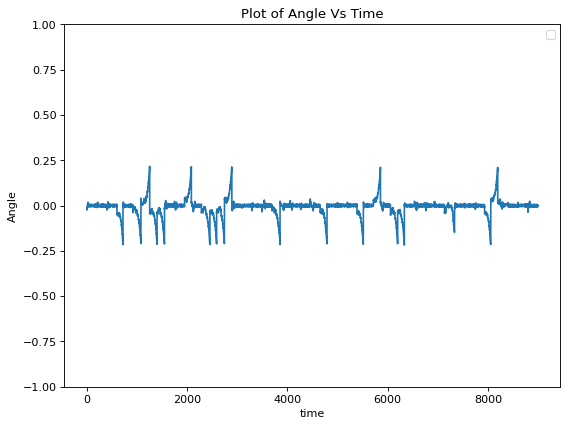

In [20]:
plt.figure(figsize=(8, 6), dpi=80)
plt.ylim([-1, 1])
plt.plot(timelist,anglelist)
#plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Plot of Angle Vs Time')
plt.xlabel('time')
plt.ylabel('Angle')
plt.show()

No handles with labels found to put in legend.


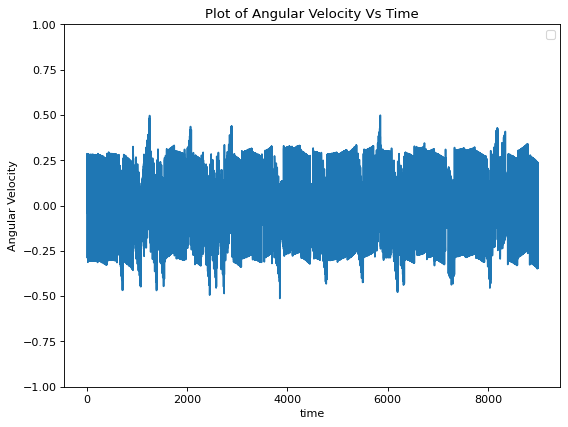

In [21]:
plt.figure(figsize=(8, 6), dpi=80)
plt.ylim([-1, 1])
plt.plot(timelist,vel)
#plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Plot of Angular Velocity Vs Time')
plt.xlabel('time')
plt.ylabel('Angular Velocity')
plt.show()